# Chapter 8. Joins
- Chapter 7 Focus: Aggregating multiple datasets using joins.
- Importance of Joins: Joins are crucial in Spark due to the need to combine data from various sources.
- Spark's Advantage: Ability to connect with different data sources provides access to diverse data within a company.
- Chapter Content:
  - Types of joins in Spark and their usage.
  - Basic internal mechanisms of joins in Spark.
  - How to avoid memory issues and solve complex problems using joins.

## Joins Expressions
- Join Functionality:
  - Merges two datasets: a *left* and a *right* dataset.
  - Compares one or more keys between the two datasets.
  - Evaluates a join expression to determine if data should be combined.
- *Equi-Join*:
  - Most common type of join expression.
  - Checks if specified keys in both datasets are equal.
  - Combines datasets if keys match, discards rows if keys don't match.
- Spark's Join Capabilities:
  - Supports more complex join policies beyond *equi-joins*.
  - Allows use of complex data types.
  - Can perform joins based on conditions like checking if a key exists within an array.

## Join Types
- Join Types in Spark:
  - ***Inner joins***: Keeps rows with keys that exist in both the left and right datasets.
  - ***Outer joins***: Keeps rows with keys in either the left or right dataset.
  - ***Left outer joins***: Keeps rows with keys in the left dataset.
  - ***Right outer joins***: Keeps rows with keys in the right dataset.
  - ***Left semi joins***: Keeps rows in the left dataset where the key appears in the right dataset.
  - ***Left anti joins***: Keeps rows in the left dataset where the key does not appear in the right dataset.
  - ***Natural joins***: Performs a join by implicitly matching the columns with the same names in both datasets.
  - ***Cross (or Cartesian) joins***: Matches every row in the left dataset with every row in the right dataset.
- Purpose:
  - Joins determine which rows should be in the result set based on different join types.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.sql.shuffle.partitions", 5)\
    .appName("PySpark Joins")\
    .getOrCreate()

24/08/09 08:50:22 WARN Utils: Your hostname, Khanhs-MAC.local resolves to a loopback address: 127.0.0.1; using 192.168.254.32 instead (on interface en0)
24/08/09 08:50:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/09 08:50:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
person = spark.createDataFrame([
    (0, "Bill Chambers", 0, [100]),
    (1, "Matei Zaharia", 1, [500, 250, 100]),
    (2, "Michael Armbrust", 1, [250, 100])])\
    .toDF("id", "name", "graduate_program", "spark_status")
graduateProgram = spark.createDataFrame([
    (0, "Masters", "School of Information", "UC Berkeley"),
    (2, "Masters", "EECS", "UC Berkeley"),
    (1, "Ph.D.", "EECS", "UC Berkeley")])\
    .toDF("id", "degree", "department", "school")
sparkStatus = spark.createDataFrame([
    (500, "Vice President"),
    (250, "PMC Member"),
    (100, "Contributor")])\
    .toDF("id", "status")

In [5]:
person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")

## Inner Joins
- Inner joins evaluate the keys in both DataFrames (or tables) and include only the rows that have matching keys in both DataFrames.;

In [11]:
joinExpression = person["graduate_program"] == graduateProgram["id"]

In [14]:
wrongJoinExpression = person["name"] == graduateProgram["school"]

In [15]:
person.join(graduateProgram, joinExpression).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



- inner join is default join 
- We can also specify this explicitly by passing in a third parameter. 

In [16]:
joinType = "inner"

person.join(graduateProgram, joinExpression, joinType).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



## Outer Joins
- Outer joins evaluate the keys in both of the DataFrames or tables and includes (and joins together).
- The rows that evaluate to true of false.

In [17]:
joinType = "outer"

person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



## Left Outer Joins
- Left outer joins evaluate the keys in both DataFrames (or tables).
- The result includes:
  - All rows from the left DataFrame.
  - Any matching rows from the right DataFrame that correspond to keys in the left DataFrame.
- If there is no matching row in the right DataFrame:
  - Spark will insert null for the columns from the right DataFrame in the resulting DataFrame.

In [18]:
joinType = "left_outer"

graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
| id| degree|          department|     school|  id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|   0|   Bill Chambers|               0|          [100]|
|  2|Masters|                EECS|UC Berkeley|NULL|            NULL|            NULL|           NULL|
|  1|  Ph.D.|                EECS|UC Berkeley|   2|Michael Armbrust|               1|     [250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|   1|   Matei Zaharia|               1|[500, 250, 100]|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+



## Right Outer Join
- Right outer joins evaluate the keys in both DataFrames (or tables).
- The result includes:
  - All rows from the right DataFrame.
  - Any matching rows from the left DataFrame that correspond to keys in the right DataFrame.
- If there is no matching row in the left DataFrame:
  - Spark will insert null for the columns from the left DataFrame in the resulting DataFrame.

In [19]:
joinType = "right_outer"

person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



## Left Semi Joins
- Behavior: Semi joins do not include any columns or values from the right DataFrame.
- Purpose: They only check if a value from the left DataFrame exists in the right DataFrame.
- Result: Rows from the left DataFrame are kept in the result if there is a matching value in the right DataFrame.
- Duplicates: Even if there are duplicate keys in the left DataFrame, all matching rows are retained.
- Function: Semi joins act more like filters on a DataFrame rather than performing a conventional join.

In [21]:
joinType = "left_semi"

graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  1|  Ph.D.|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



In [22]:
gradProgram2 = graduateProgram.union(spark.createDataFrame([
  (0, "Masters", "Duplicated Row", "Duplicated School")]))

gradProgram2.createOrReplaceTempView("gradProgram2")
gradProgram2.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------------+
| id| degree|          department|           school|
+---+-------+--------------------+-----------------+
|  0|Masters|School of Informa...|      UC Berkeley|
|  1|  Ph.D.|                EECS|      UC Berkeley|
|  0|Masters|      Duplicated Row|Duplicated School|
+---+-------+--------------------+-----------------+



## Left Anti Joins
- Behavior: Like left semi joins, left anti joins do not include any columns or values from the right DataFrame.
- Purpose: They compare values from the left DataFrame against the right DataFrame.
- Result: Rows from the left DataFrame are kept in the result if there is no matching value in the right DataFrame.
- Function: Left anti joins act like a SQL-style NOT IN filter, keeping only the rows from the left DataFrame that do not have corresponding keys in the right DataFrame.

In [23]:
joinType = "left_anti"
graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+----------+-----------+
| id| degree|department|     school|
+---+-------+----------+-----------+
|  2|Masters|      EECS|UC Berkeley|
+---+-------+----------+-----------+



## Natural Joins
- They make implicit guesses about the columns on which you would like to join.
- Natural joins find matching columns and return results, supporting left, right, and outer joins.
- Caution: Implicit matching can be dangerous. The join may give incorrect results if the matching columns have the same name but represent different things in the datasets.
- Example Warning: Joining on a shared column name like id could lead to misleading results if the id refers to different things in the two tables.

## Cross (Certesian) Joins
- Definition: Cross-joins are a type of inner join that does not specify a predicate.
- Functionality: This join type matches every row in the left DataFrame with every row in the right DataFrame.
- Impact: The result is a significant increase in the number of rows in the resulting DataFrame. For example, if each DataFrame has 1,000 rows, the result will have 1,000,000 rows.
- Explicitness Required: Due to the potential for creating very large datasets, you must explicitly state that you want a cross-join by using the cross join keyword.

In [24]:
joinType = "cross"
graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
| id| degree|          department|     school| id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|  0|   Bill Chambers|               0|          [100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  2|Michael Armbrust|               1|     [250, 100]|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+



In [25]:
person.crossJoin(graduateProgram).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  0|   Bill Chambers|               0|          [100]|  2|Masters|                EECS|UC Berkeley|
|  0|   Bill Chambers|               0|          [100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  2|Masters|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  0|Masters|School of Informa...|UC 

> - Explicit Requirement: Cross-joins are inherently risky due to the potential to create very large datasets.
>- Danger: They can dramatically increase the number of rows in the resulting DataFrame, leading to performance issues.
>- Advanced Users: To use cross-joins without warnings or Spark attempting a different join, set the session-level configuration spark.sql.crossJoin.enable to true.
>- Recommendation: Only use cross-joins if you are absolutely certain that they are necessary for your specific use case.

## Challenges When Using Joins


### Joins on Complex Types;

In [27]:
from pyspark.sql.functions import expr

person.withColumnRenamed("id", "personId")\
  .join(sparkStatus, expr("array_contains(spark_status, id)")).show()

+--------+----------------+----------------+---------------+---+--------------+
|personId|            name|graduate_program|   spark_status| id|        status|
+--------+----------------+----------------+---------------+---+--------------+
|       0|   Bill Chambers|               0|          [100]|100|   Contributor|
|       1|   Matei Zaharia|               1|[500, 250, 100]|500|Vice President|
|       1|   Matei Zaharia|               1|[500, 250, 100]|250|    PMC Member|
|       1|   Matei Zaharia|               1|[500, 250, 100]|100|   Contributor|
|       2|Michael Armbrust|               1|     [250, 100]|250|    PMC Member|
|       2|Michael Armbrust|               1|     [250, 100]|100|   Contributor|
+--------+----------------+----------------+---------------+---+--------------+



### Handling Duplicate Column Names
- Unique Column IDs in Spark:
  - Each column in a DataFrame has a unique ID within Spark’s SQL Engine, Catalyst, which is internal and not directly referenceable.
- Challenges with Duplicate Column Names:
  - Situation 1: Occurs when the join expression does not remove one key from one of the input DataFrames, resulting in duplicate column names if the keys have the same column name.
  - Situation 2: Happens when two columns, which are not part of the join, share the same name across the input DataFrames.
- Approach 1: Different Join Expression 
  - Change the join expression from a Boolean to a string or sequence. This will automatically remove one of the duplicate columns during the join.
- Approach 2: Dropping the Column After the Join
  - Drop the duplicate column after performing the join. To do this, reference the column via the original source DataFrame to resolve the correct column by its specific ID.
- Approach 3: Renaming a Column Before the Join
  - Avoid the issue by renaming one of the columns before performing the join. This ensures that there are no duplicate column names during the join operation.


## How Spark Performs Joins
- Node-to-Node Communication Strategy: This refers to how data is exchanged between different nodes in a cluster during a join operation.
- Per Node Computation Strategy: This refers to how each node processes the data locally during the join operation.
- Relevance: While these technical details may seem irrelevant to the business problem at hand, understanding them is crucial for optimizing performance. The efficiency of joins can significantly impact whether a job completes quickly or becomes inefficient and potentially fails.

### Communication Strategies
- Spark’s Join Strategies: Spark uses two primary strategies during joins:
  - Shuffle Join: Involves all-to-all communication between nodes, which can be resource-intensive.
  - Broadcast Join: Involves broadcasting a small table to all nodes to join with a larger table, which is more efficient for smaller tables.
- Focus on High-Level Understanding: The details of these strategies and their optimizations may evolve over time, so focusing on high-level concepts is more practical for understanding and improving performance.
- Big Table vs. Small Table: In Spark, join strategies often depend on whether you’re working with a big table or a small table. While this is a simplification, it helps in deciding the most efficient join strategy for your workloads.
- Performance Optimization: Understanding these basic join strategies allows you to optimize your workloads by choosing the right approach based on the size of the tables involved.

#### Big table-to-big table
- When you join a big table to another big table, you end up with a shuffle join like this.

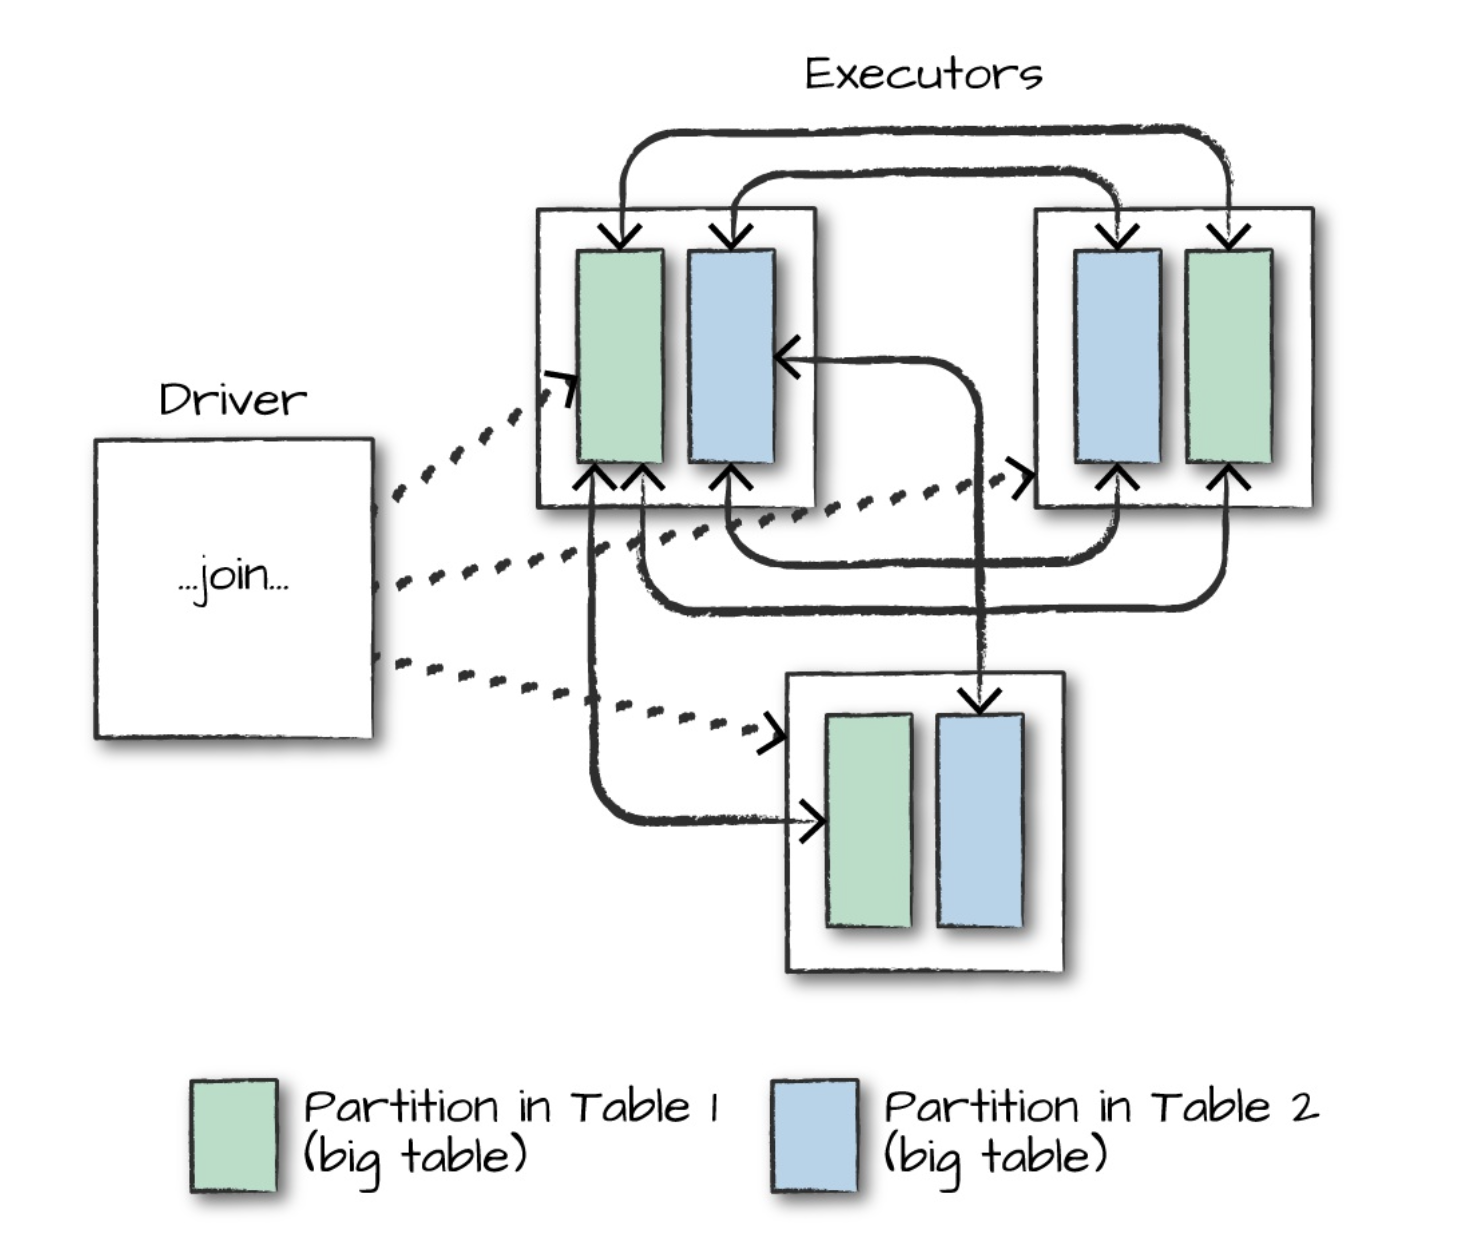

- Node Communication: In a shuffle join, every node communicates with every other node, sharing data based on the keys involved in the join.
- Resource Intensity: This join is resource-intensive and can congest the network, especially if the data isn’t partitioned well.
- Use Case Example: Commonly used when joining two large tables of data, such as analyzing billions of IoT messages to identify day-over-day changes.
- DataFrame Interaction: All worker nodes and partitions may need to communicate during the join, resulting in high resource usage, particularly when both DataFrames are large.

#### Big table-to-small table
- Broadcast Join: A broadcast join is used when a small table can fit into the memory of a single worker node. This method is more efficient than a shuffle join, especially when joining a large table with a small table.
- Process:
	1.	The driver node creates a broadcast variable from the small table.
	2.	This broadcast variable is sent to each executor in the cluster.
	3.	Each executor then performs the join locally with the broadcasted small table, avoiding the need for expensive all-to-all communication.
- Efficiency: The broadcast join reduces the communication overhead between nodes, making it faster for certain types of joins. It is especially useful when the small table is significantly smaller than the large table.

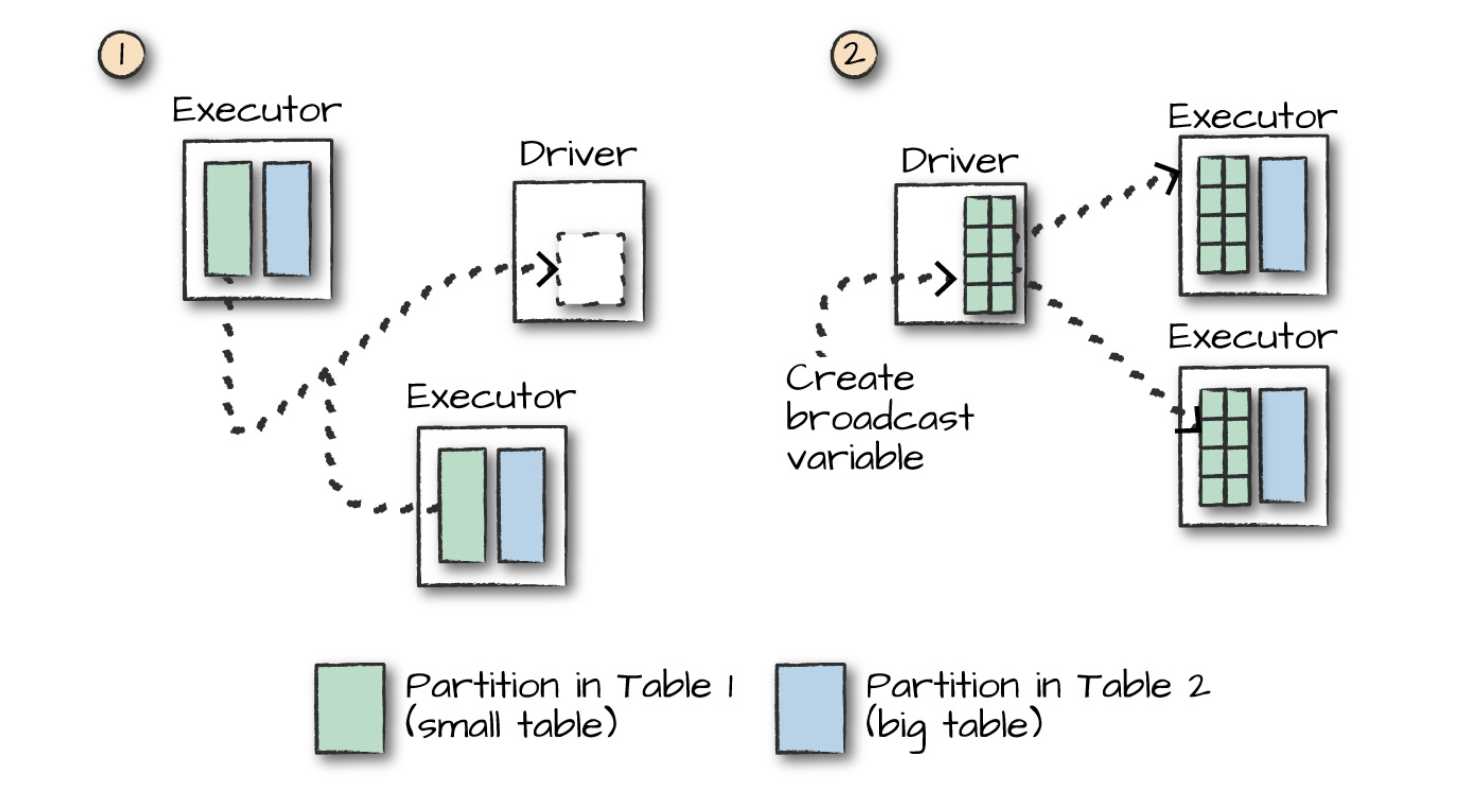

- Broadcast Join Process:
	- Spark first performs a large communication at the start of the join process, similar to a shuffle join.
	- After the initial communication, each worker node performs the join individually, reducing the need for further node-to-node communication.
	- This method allows Spark to avoid network congestion and leverage CPU resources on individual nodes.
- Explain Plan:
	- The explain() method in Spark can be used to visualize the physical plan of a DataFrame operation.
	- In this case, Spark has automatically optimized the join as a broadcast join, indicated by the terms BroadcastHashJoin and BroadcastExchange.
- Manual Optimization:
	- You can manually instruct Spark to perform a broadcast join by using the broadcast function.
	- This can be done with the DataFrame API or by providing hints in SQL queries (e.g., MAPJOIN, BROADCAST, and BROADCASTJOIN).
- Risks:
	- While broadcast joins are efficient, they can lead to driver node crashes if the broadcasted data is too large for memory.
	- It’s essential to carefully consider when to use broadcast joins, especially for large datasets.


#### Little table–to–little table
- When performing joins with small tables, it’s usually best to let Spark decide how to join them. 
- You can always force a broadcast join if you’re noticing strange behavior.


## Conclusion
- Importance of Joins: Joins are one of the most common operations in data processing.
- Data Partitioning: Properly partitioning data before performing joins can significantly improve execution efficiency. Spark can sometimes avoid shuffles if the necessary data is already on the same machine.
- Experimentation: It’s recommended to experiment with data partitioning to observe speed improvements in join operations.
- Order of Joins: The order in which joins are performed can have a big impact on performance, especially since some joins can act as filters, reducing data exchanged over the network.